In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
%matplotlib inline


In [3]:
labels = pd.read_csv('p1_labels.csv')
print(labels.info())
print("\nLabels has {} unique amt_labels".format(len(labels.amt_labeled.unique())))
print("Labels has {} unique Claim Id's\n".format(len(labels.ClaimId.unique())))
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4716 entries, 0 to 4715
Data columns (total 3 columns):
ClaimId        4716 non-null int64
id_labeled     4716 non-null int64
amt_labeled    4716 non-null float64
dtypes: float64(1), int64(2)
memory usage: 110.6 KB
None

Labels has 2984 unique amt_labels
Labels has 2473 unique Claim Id's



,ClaimId,id_labeled,amt_labeled
0,1,1,301.54
1,1,2,105.00
2,2,3,62.95
3,2,4,577.82
4,3,5,42.72


In [3]:
items = pd.read_csv('p1_lineitems.csv')
print(items.info())
print("\nItems has {} unique amt_lineitem".format(len(items.amt_lineitem.unique())))
print("Items has {} unique Claim Id's\n".format(len(items.ClaimId.unique())))
items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13551 entries, 0 to 13550
Data columns (total 4 columns):
ClaimId         13551 non-null int64
id_lineitem     13551 non-null int64
amt_lineitem    13551 non-null float64
features        13551 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 423.5+ KB
None

Items has 5074 unique amt_lineitem
Items has 2465 unique Claim Id's



,ClaimId,id_lineitem,amt_lineitem,features
0,1,1,105.00,x
1,1,2,105.94,x
2,1,3,12.24,x
3,1,4,20.00,x
4,1,5,51.37,x


In [4]:
p2data = pd.read_csv('p2_data.csv', index_col = 0, encoding = "ISO-8859-1") #simplest text encoding
print(p2data.info())
print("\nData has {} unique Diagnosis".format(len(p2data.Diagnosis.unique())))
print("Data has {} unique ItemDescriptions".format(len(p2data.ItemDescription.unique())))
print("Data has {} unique PreventiveFlags:{} \n {}".format(len(p2data.PreventiveFlag.unique()),
                                                           p2data.PreventiveFlag.unique(), 
                                                           p2data.PreventiveFlag.value_counts()))
print("Data has {} null PreventiveFlags\n".format(p2data.PreventiveFlag.isnull().sum()))
p2data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 1 to 11000
Data columns (total 3 columns):
ItemDescription    11000 non-null object
Diagnosis          11000 non-null object
PreventiveFlag     10000 non-null float64
dtypes: float64(1), object(2)
memory usage: 343.8+ KB
None

Data has 2266 unique Diagnosis
Data has 10475 unique ItemDescriptions
Data has 3 unique PreventiveFlags:[ 0.  1. nan] 
 0.0    9322
1.0     678
Name: PreventiveFlag, dtype: int64
Data has 1000 null PreventiveFlags



,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


---
## Part 1 – Preparing a usable dataset

- When we receive invoice data from our customers, it is structured by line item. 
- Trupanion then aggregates one or many line items to a higher level category for payment or denial. 
- One of our end goals is to automate this line item grouping by categorizing each invoice line item. 
- In order to do so, we must essentially undo that aggregation, so you must first map each line item to the appropriate group. 
- Our labels (in file ...labels) must be linked to our features (in file ...lineitems).

Use the files named p1_labels.csv and p1_lineitems.csv to map as many line item data ids to labeled ids as possible.
Hints:
- “ClaimId” is a common index shared between the csvs
- The expected solution is a list of mappings from id_lineitem to id_labeled
- Not all line item data ids can be mapped
- Submit your work alongside your solution
    - We typically use python/jupyter notebook, but any similar language or tool is acceptable 
- I’ve included a “features” column as a reminder of our end goal – nothing needs to be done with it

In [6]:
# Merge by ClaimID, If there is no match, the missing side will contain null. 
df = pd.merge(items, labels, on='ClaimId', how='outer')
print(df.shape,"\nThere were {} records not matched from the data table".format(df.isnull().sum().features))
df.loc[df.id_lineitem.isnull()]

(30930, 6) 
There were 9 records not matched from the data table


,ClaimId,id_lineitem,amt_lineitem,features,id_labeled,amt_labeled
30921,190,NaN,NaN,NaN,425,0.00
30922,821,NaN,NaN,NaN,1633,0.00
30923,1413,NaN,NaN,NaN,2753,0.00
30924,1669,NaN,NaN,NaN,3217,0.00
30925,1868,NaN,NaN,NaN,3597,94.28
30926,1868,NaN,NaN,NaN,3598,50.92
30927,1893,NaN,NaN,NaN,3645,0.00
30928,1898,NaN,NaN,NaN,3656,0.00
30929,2209,NaN,NaN,NaN,4214,0.00


In [7]:
# Lets remove them for now
df = pd.merge(items, labels, on='ClaimId', how='inner')
print(df.shape)
df.head()

(30921, 6)


,ClaimId,id_lineitem,amt_lineitem,features,id_labeled,amt_labeled
0,1,1,105.00,x,1,301.54
1,1,1,105.00,x,2,105.00
2,1,2,105.94,x,1,301.54
3,1,2,105.94,x,2,105.00
4,1,3,12.24,x,1,301.54


---
## Part 2 – Build a text classifier

Description:
- Our product does not cover routine, wellness or preventive care. 
- We believe that costs that pet owners can expect periodically and budget for should be separate from an insurance policy meant to cover accidents and illnesses.
- Use the data contained in p2_data.csv to build a binary classifier to predict the “PreventiveFlag” label using the text features provided. 
- This model can be used to automate the detection of ineligible line items. 
- The expected output are prediction probabilities for rows 10001 through 11000, where the labels are currently null.


In [5]:
data = p2data.loc[p2data.PreventiveFlag.notnull()]
# data = data.sample(frac=0.05)

print(data.shape)
data.head()

(10000, 3)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


### EDA

In [112]:
from nltk import sent_tokenize, word_tokenize
from time import time
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Is the data balanced? 
label_true = data.PreventiveFlag.value_counts()[1]
label_false = data.PreventiveFlag.value_counts()[0]
print("{} Label 1 vs {} Label 0".format(str(label_true/(label_false+label_true)),
                         str(label_false/(label_false+label_true))))


0.0678 Label 1 vs 0.9322 Label 0


In [114]:
## ----  Statistics
# Length of ItemDescription
ItemDescription_lengths = [len(item[1].ItemDescription) for item in data.iterrows()]
Diagnosis_lengths = [len(item[1].Diagnosis) for item in data.iterrows()]

# Distribution of number of sentences in Item Descriptions: 
sentence_count_per_item = [len(sent_tokenize(item[1].ItemDescription)) for item in data.iterrows()]
sentence_count_per_diagnosis = [len(sent_tokenize(item[1].Diagnosis)) for item in data.iterrows()]

# Word count in ItemDescription
ItemDescription_word_count = [len(word_tokenize(item[1].ItemDescription)) for item in data.iterrows()]
Diagnosis_word_count = [len(word_tokenize(item[1].Diagnosis)) for item in data.iterrows()]

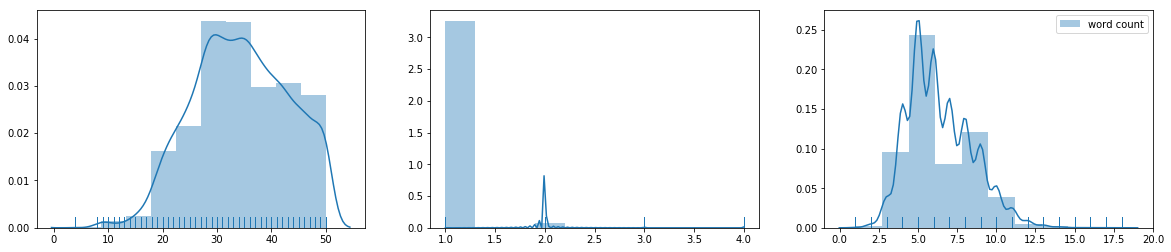

293.96268486976624


In [115]:
# create 3 subplots (horizontally stacked)    ~ 293 s
start = time()
f, axarr = plt.subplots(1,3,figsize=(20,4))

sns.distplot(ItemDescription_lengths, bins=10, rug=True, ax=axarr[0], label="length")
sns.distplot(sentence_count_per_item, bins=10, rug=True, ax=axarr[1], label="sentence count")
sns.distplot(ItemDescription_word_count, bins=10, ax=axarr[2], rug=True, label="word count")
plt.legend()
plt.show()
print(time()-start)

In [116]:
# Check out the longest Item Descriptions: 
indices = [i for i, x in enumerate(ItemDescription_lengths) if x == max(ItemDescription_lengths)]
print(data.iloc[indices[0]].ItemDescription)

# Check out the Item Descriptions with the most number of dots:
indices = [i for i, x in enumerate(sentence_count_per_item) if x == max(sentence_count_per_item)]
print(data.iloc[indices[0]].ItemDescription)

# Check out those with max word count
indices = [i for i, x in enumerate(ItemDescription_word_count) if x == max(ItemDescription_word_count)]
print(data.iloc[indices[0]].ItemDescription)

Cooper Tru50:  Fenbendazol(Panacur)222mg/gGran(p#D
Grizzly:  NPD - NeoPoly Dex. Oph. Oint. #53149
Cooper Max:  CYTOPOINT 40.0-50#(1(10 mg) 1(40 mg))


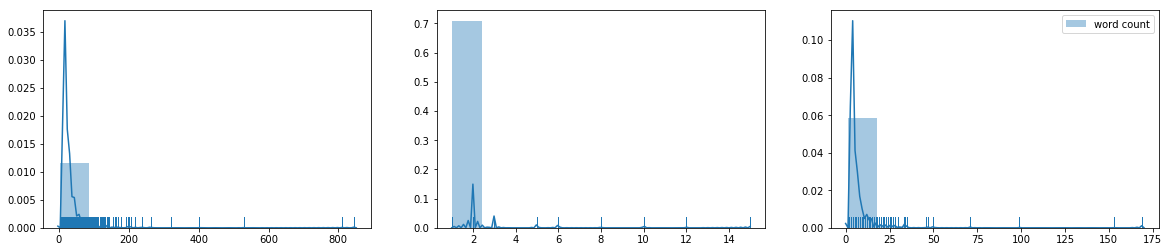

316.9646248817444


In [117]:
# create 3 subplots (horizontally stacked)   ~ 316s 
start = time()
f, axarr = plt.subplots(1,3,figsize=(20,4))

sns.distplot(Diagnosis_lengths, bins=10, rug=True, ax=axarr[0], label="length")
sns.distplot(sentence_count_per_diagnosis, bins=10, rug=True, ax=axarr[1], label="sentence count")
sns.distplot(Diagnosis_word_count, bins=10, ax=axarr[2], rug=True, label="word count")
plt.legend()
plt.show()
print(time()-start)

In [156]:
# Check out the longest Item Descriptions: 
indices = [i for i, x in enumerate(Diagnosis_lengths) if x == max(Diagnosis_lengths)]
print(data.iloc[indices[0]].Diagnosis, '\n')

# Check out the Item Descriptions with the most number of dots:
indices = [i for i, x in enumerate(sentence_count_per_diagnosis) if x == max(sentence_count_per_diagnosis)]
print(data.iloc[indices[0]].Diagnosis, '\n')

# Check out those with max word count
indices = [i for i, x in enumerate(Diagnosis_word_count) if x == max(Diagnosis_word_count)]
print(data.iloc[indices[0]].Diagnosis)


immune mediated polyarthritis bar happier and interactive today ulcerated erythema skin nose and rostral muzzle jt swelling over hocks stifles and carpi significantly reduced waxy erythema au spots of erythema inner pinna muzzle nose ulceration erythema r o immunemediated rxn to fluroquinolones open stop baytril and osurnia use flush out osurnia from ears stop tx for ears for now continue pred as directed a o will need taper depending on response recheck pe and labs health chek in 2 wks add vit e and 

vomiting 

immune mediated polyarthritis bar happier and interactive today ulcerated erythema skin nose and rostral muzzle jt swelling over hocks stifles and carpi significantly reduced waxy erythema au spots of erythema inner pinna muzzle nose ulceration erythema r o immunemediated rxn to fluroquinolones open stop baytril and osurnia use flush out osurnia from ears stop tx for ears for now continue pred as directed a o will need taper depending on response recheck pe and labs health che

In [ ]:
data['ItemDescription'] = data.ItemDescription.apply(remove_punctuation2)
data['Diagnosis'] = data.Diagnosis.apply(remove_punctuation1)
data.head()

In [ ]:
# Stemming or Lemmatization?
stemmer = PorterStemmer()
data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

lemmer = WordNetLemmatizer()
# data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
# data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
data.head()
# # Remove stopwords in diagnosis... maybe

### Preprocessing

In [7]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/iZbra1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Replace slash with space
# Remove punctuation and extra spaces
# Convert to lower case ?? Not the Item Description, yes for diagnosis
def remove_punctuation1(i_desc):
    pattern = r"[^\w\s]"
    idesc = re.sub(r"/", ' ', i_desc).lower()
    return " ".join(re.sub(pattern, '', idesc).split()) 

# Just word_tokenize: for ItemDescription
# The first word on the IDesc is a proper name. 
def remove_punctuation2(i_desc):
    return " ".join(word_tokenize(i_desc))

def preprocessing(df):
    
    # Remove punctuation
    df['ItemDescription'] = df.ItemDescription.apply(remove_punctuation2)
    df['Diagnosis'] = df.Diagnosis.apply(remove_punctuation1)
    
    # Stemming
    stemmer = PorterStemmer()
    df['ItemDescription'] = df.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    df['Diagnosis'] = df.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    
    return df.ItemDescription.values + " " + df.Diagnosis.values
    
def vectorizer(train, corpus_all, vectorizer_count, vectorizer_tf):
    
    # Model: 
    #  vectorizer.vocabulary_
    #  vectorizer.get_feature_names()
    
    if train:
        vectorizer_count = CountVectorizer(token_pattern='[a-zA-Z]{2,}', stop_words='english')
        one_hot = vectorizer_count.fit_transform(corpus_all)
    else: 
        vectorizer_count._validate_vocabulary()
        one_hot = vectorizer_count.transform(corpus_all)
    
    # TFIDF
    # Term frequency: this summarizes how often a given word appears within a document
    # Inverse document frequency: This downscales words that appear a lot across documents
    # Transforming the matrix based on the learnt frequencies or weights
    # vectorizer_tf.idf_
    
    if train:
        vectorizer_tf = TfidfTransformer()
        freq = vectorizer_tf.fit_transform(one_hot)
    else: 
        freq = vectorizer_tf.transform(one_hot)
    
    return freq.toarray(), vectorizer_count, vectorizer_tf

array(['georg : offic call/gener exam diarrhea vomit congest',
       'shayna : leptospirosi vaccin transit cell carcinoma work up for transit cell carcinoma if you have question pleas call me at 9529994197 sara aho',
       'emma : fecal floatat exam traumadead tooth ear infect dead tooth found on exam and need to be remov surgeri is schedul blood work xray blood pressur are all pre surgic workup ear cytolog and osurnia for ear infect fecal is well pleas call with ani question',
       ..., 'shad : metronidazol 500 mg diarrhea',
       'jack : radiograph 1st exposur ill recheck radiograph',
       'jack : antisedan inject ill recheck radiograph'], dtype=object)

In [9]:
# Splitting the dataset

test = p2data.loc[p2data.PreventiveFlag.isnull()]
data = p2data.loc[p2data.PreventiveFlag.notnull()]

msk = np.random.rand(len(data)) < 0.8

train = preprocessing(data[msk])
validation = preprocessing(data[~msk])

X_train, vc, vt = vectorizer(True, train, False, False)
y_train = data[msk].PreventiveFlag.values

X_val, vc, vt = vectorizer(False, validation, vc, vt)
y_val = data[~msk].PreventiveFlag.values

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(7944, 4893) (7944,) (2056, 4893) (2056,)


### Training and Evaluation: 

In [129]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, \
                            mean_squared_error, accuracy_score, f1_score, \
                            precision_score, recall_score
from sklearn import metrics


In [190]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# clf = LogisticRegression(random_state=42).fit(X_train, y_train) # ~11s
# clf = MultinomialNB().fit(X_train, y_train)
# clf = SGDClassifier(random_state=42).fit(X_train, y_train) # ~ 13s
# clf = DecisionTreeClassifier(max_depth=2, random_state=42).fit(X_train, y_train) # ~ 40s



In [191]:
# Bayes classifier
# Normalizing bag-of-words features with the tf-idf algorithm

start = time()

clf = DummyClassifier().fit(X_train, y_train) # ~ 6s
y_val_pred = clf.predict(X_val)

# These predictions can then be used to evaluate the classifier:

y_train_scores = cross_val_score(clf, X_train, y_train, cv=10)
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=10)

print(time()-start)

6.79936408996582


In [192]:
# Evaluation Metrics:
train_acc = round(y_train_scores.mean(),3)
train_roc = round(roc_auc_score(y_train, y_train_pred),3)
train_mse = round(mean_squared_error(y_train, y_train_pred),3)
train_prec = precision_score(y_train, y_train_pred, average=None)
train_recl = recall_score(y_train, y_train_pred, average=None)
train_f1 = f1_score(y_train, y_train_pred, average=None)
train_report = metrics.classification_report(y_train, y_train_pred, target_names=['class 0', 'class 1'])

results = pd.DataFrame({'Acc':train_acc, 
                        'Prec_C0':round(train_prec[0],3),
                        'Prec_C1':round(train_prec[1],3),
                        'Recal_C0':round(train_recl[0],3),
                        'Recal_C1':round(train_recl[1],3),
                        'F1_C0':round(train_f1[0],3),
                        'F1_C1':round(train_f1[1],3),
                        'AUC':train_roc, 
                        'MSE':train_mse}, index=['Training'])


print('With weighted-average:\n{}'.format(train_report))
results.head()

With weighted-average:
             precision    recall  f1-score   support

    class 0       0.93      0.93      0.93      7405
    class 1       0.08      0.08      0.08       539

avg / total       0.87      0.87      0.87      7944



,AUC,Acc,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C2
Training,0.506,0.875,0.933,0.079,0.126,0.933,0.079,0.932,0.08


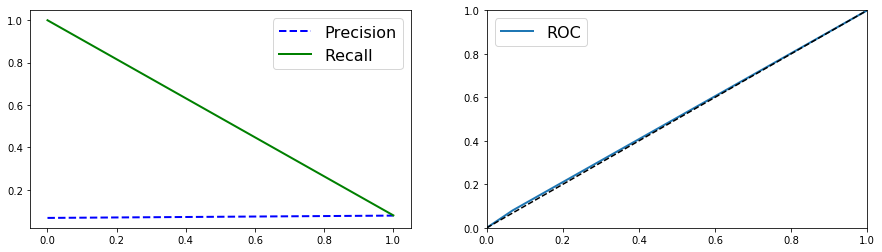

In [193]:
def plot_curves(y_train, y_train_pred):
    # create 2 subplots (horizontally stacked)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    precision, recall, f = precision_recall_curve(y_train, y_train_pred)

    fig, axarr = plt.subplots(1,2,figsize=(15,4))

    axarr[0].plot(f, precision[:-1], "b--", label="Precision", linewidth=2)
    axarr[0].plot(f, recall[:-1], "g-", label="Recall", linewidth=2)
    axarr[0].legend(loc="top", fontsize=16)

    # axarr[0].xlabel("Threshold", fontsize=16)
    # axarr[0].ylim([0, 1])

    axarr[1].plot(fpr, tpr, linewidth=2, label='ROC')
    axarr[1].plot([0, 1], [0, 1], 'k--')
    axarr[1].axis([0, 1, 0, 1])
    axarr[1].legend(loc="upper left", fontsize=16)

    plt.show()

plot_curves(y_train, y_train_pred)

#### Validation

In [194]:
# Is it overfitting?
val_acc = round(accuracy_score(y_val, y_val_pred),3)
val_roc = round(roc_auc_score(y_val, y_val_pred),3)
val_mse = round(mean_squared_error(y_val, y_val_pred),3)
val_prec = precision_score(y_val, y_val_pred, average=None)
val_recl = recall_score(y_val, y_val_pred, average=None)
val_f1 = f1_score(y_val, y_val_pred, average=None)
val_report = metrics.classification_report(y_val, y_val_pred, target_names=['class 0', 'class 1'])

results = pd.concat([results, pd.DataFrame({'Acc':val_acc, 
                        'Prec_C0':round(val_prec[0],3),
                        'Prec_C1':round(val_prec[1],3),
                        'Recal_C0':round(val_recl[0],3),
                        'Recal_C1':round(val_recl[1],3),
                        'F1_C0':round(val_f1[0],3),
                        'F1_C1':round(val_f1[1],3),
                        'AUC':val_roc, 
                        'MSE':val_mse}, index=['Validation'])])


print('With weighted-average:\n{}'.format(val_report))
results.head()


With weighted-average:
             precision    recall  f1-score   support

    class 0       0.93      0.93      0.93      1917
    class 1       0.07      0.07      0.07       139

avg / total       0.87      0.87      0.87      2056



,AUC,Acc,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C2
Training,0.506,0.875,0.933,0.079,0.126,0.933,0.079,0.932,0.080
Validation,0.502,0.874,0.932,0.071,0.126,0.933,0.071,0.932,0.072


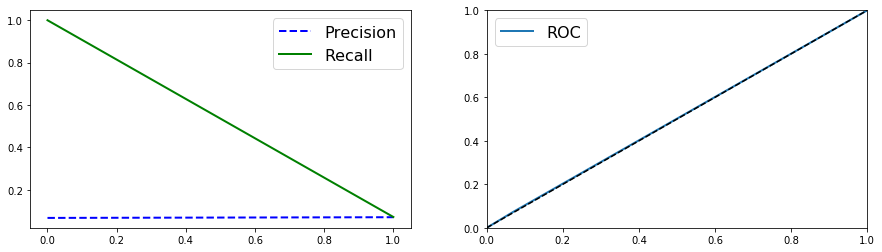

In [195]:
plot_curves(y_val, y_val_pred)

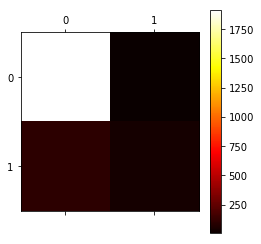

In [141]:
plt.matshow(metrics.confusion_matrix(y_val, predicted), cmap=plt.cm.hot)
plt.colorbar()
plt.show()

# Answer: 
- Dealing with unbalanced dataset: 
    - Even up the training set: train the model with all of the minority class instances and an almost same amount of instances of the majority class. 

In [ ]:


X_test = preprocessing(test, False)
y_test = test.PreventiveFlag.values